# 實現PCA演算法

## 建立測試資料:兩份資料，3個特徵，各20筆。

In [1]:
import numpy as np

# 固定隨機種子
np.random.seed(2342347) 

# 第一個類別
mu_vec1 = np.array([0,0,0]) # 平均數
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]]) # 共變異矩陣
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20).T

# 第二個類別
mu_vec2 = np.array([1,1,1]) # 平均數
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]]) # 共變異矩陣
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20).T

class1_sample.shape, class2_sample.shape

((3, 20), (3, 20))

## 繪圖

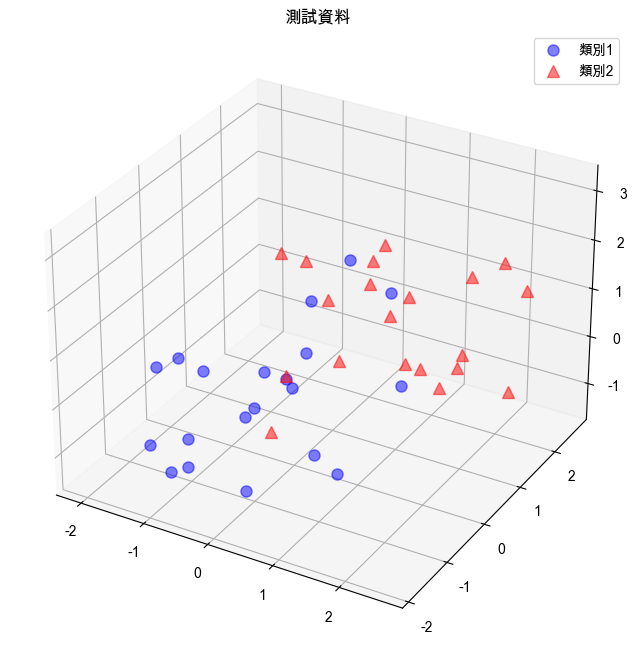

In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# 修正中文亂碼
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(class1_sample[0,:], class1_sample[1,:], class1_sample[2,:], 'o',
        markersize=8, color='blue', alpha=0.5, label='類別1')
ax.plot(class2_sample[0,:], class2_sample[1,:], class2_sample[2,:], '^', 
        markersize=8, alpha=0.5, color='red', label='類別2')

plt.title('測試資料')
ax.legend(loc='upper right')

plt.show()

## 合併資料

In [3]:
all_samples = np.concatenate((class1_sample, class2_sample), axis=1)
all_samples.shape

(3, 40)

## 計算共變異數矩陣(covariance matrix)

In [4]:
cov_mat = np.cov([all_samples[0,:],all_samples[1,:],all_samples[2,:]])
print('共變異數矩陣:\n', cov_mat)

共變異數矩陣:
 [[1.36790829 0.5946331  0.55037625]
 [0.5946331  1.35388385 0.450125  ]
 [0.55037625 0.450125   1.31086216]]


## 計算特徵向量(eigenvector)及對應的特徵值(eigenvalue, λ)

In [5]:
# 計算特徵值(eigenvalue)及對應的特徵向量(eigenvector)
eig_val_sc, eig_vec_sc = np.linalg.eig(cov_mat)

print('特徵向量:\n', eig_vec_sc)
print('特徵值:\n', eig_val_sc)

特徵向量:
 [[ 0.6131328   0.78845466 -0.04906558]
 [ 0.57507225 -0.48805716 -0.65657606]
 [ 0.54162726 -0.37435206  0.75266224]]
特徵值:
 [2.4118188  0.73851328 0.88232222]


## 繪製特徵向量

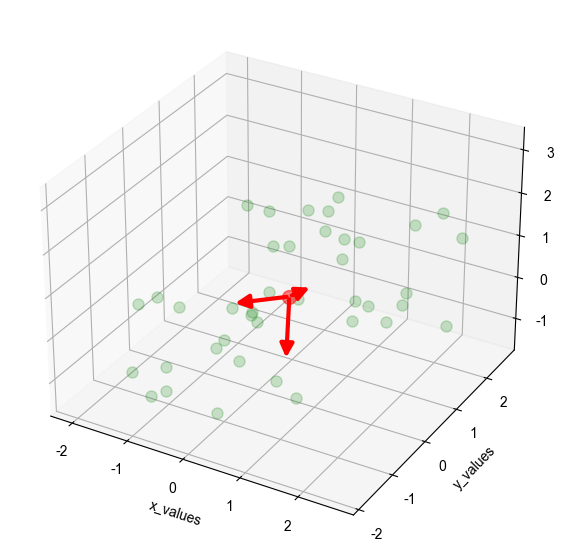

In [6]:
from mpl_toolkits.mplot3d import Axes3D, proj3d
from matplotlib.patches import FancyArrowPatch

# 繪製箭頭
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        return np.min(zs)
    
# 設定 3D 繪圖    
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# 繪製特徵向量
ax.plot(all_samples[0,:], all_samples[1,:], all_samples[2,:], 'o', 
        markersize=8, color='green', alpha=0.2)
[mean_x, mean_y, mean_z] = np.mean(all_samples, axis=1)
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', 
        alpha=0.5)
for v in eig_vec_sc.T:
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], [mean_z, v[2]], 
                mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel('x_values');ax.set_ylabel('y_values');ax.set_zlabel('z_values');

## 合併特徵向量及特徵值，針對特徵值降冪排序，挑出前2名。

In [7]:
# 合併特徵向量及特徵值
eig_pairs = [(np.abs(eig_val_sc[i]), eig_vec_sc[:,i]) for i in range(len(eig_val_sc))]

# 針對特徵值降冪排序
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# 挑出前2名
for i in eig_pairs[:2]:
    print(i[1])

[0.6131328  0.57507225 0.54162726]
[-0.04906558 -0.65657606  0.75266224]


## 座標轉換矩陣

In [8]:
matrix_w = np.stack((eig_pairs[0][1], eig_pairs[1][1]), axis=1)
print('Matrix W:\n', matrix_w)

Matrix W:
 [[ 0.6131328  -0.04906558]
 [ 0.57507225 -0.65657606]
 [ 0.54162726  0.75266224]]


## 原始資料乘以轉換矩陣，得到主成分

In [9]:
transformed = matrix_w.T.dot(all_samples)
transformed.shape

(2, 40)

## 繪製轉換後的資料

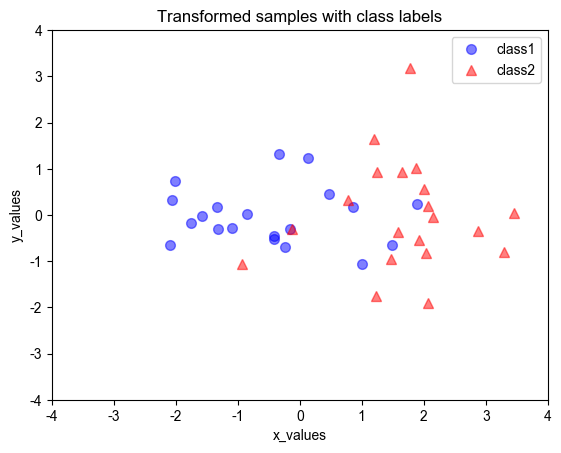

In [10]:
plt.plot(transformed[0,0:20], transformed[1,0:20], 'o', 
         markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[0,20:40], transformed[1,20:40], '^', 
         markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples with class labels');

## 降維至2個特徵，分類結果稍差，但不離譜。